# Cancer Detection 
----
A model to distinguish between malignant and benign skin lesions. This is based on the [following paper in nature](https://www.nature.com/articles/nature21056.epdf?author_access_token=8oxIcYWf5UNrNpHsUHd2StRgN0jAjWel9jnR3ZoTv0NXpMHRAJy8Qn10ys2O4tuPakXos4UhQAFZ750CsBNMMsISFHIKinKDMKjShCpHIlYPYUHhNzkn6pSnOCt0Ftf6) which showed excellent results relative to human dematologist controls. This paper even made the cover of the Nature Journal in which it was published due to the ground-breaking nature of the reserach. 



<div style="text-align:center">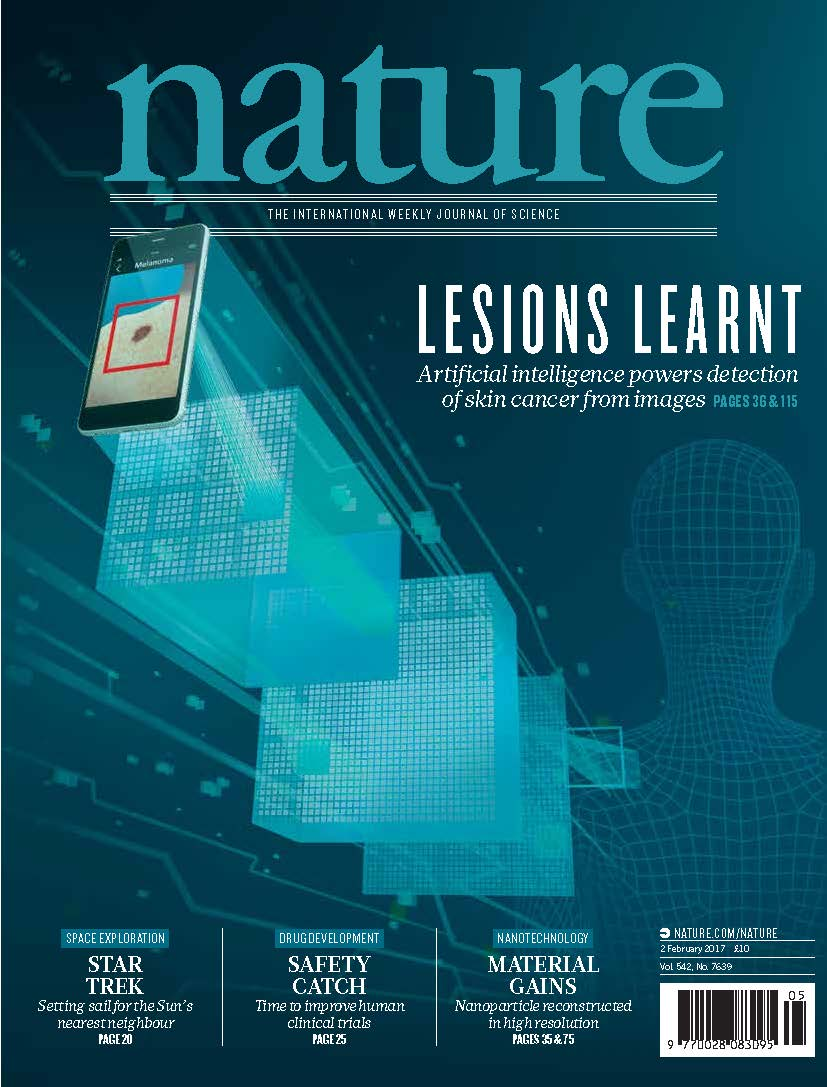

# Let's begin
----

In [28]:
import os
import numpy as np
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets
import torchvision.models as models
import torchvision.transforms as transforms

## Load in the datasets
----
Info on how to obtain the datasets is contained in the README.md. Data augmentation techniques are applied in the data loader here to be applied to the training data. 

In [32]:
### Write data loaders for training, validation, and test sets
## Specify appropriate transforms, and batch_sizes
train_transfoms = transforms.Compose([transforms.Resize((299 , 299))
                              ,transforms.RandomRotation(degrees = 10)
                              ,transforms.RandomHorizontalFlip(p=0.25)
                              ,transforms.RandomGrayscale(p=0.25)
                              ,transforms.RandomVerticalFlip(p=0.25)
                              ,transforms.ToTensor()
                              ,transforms.Normalize(mean=[0.5, 0.5, 0.5]
                                                   , std=[0.5,0.5,0.5])
                              ])

test_val_transfomrs = transforms.Compose([transforms.Resize((224, 224))
                              ,transforms.ToTensor()
                              ,transforms.Normalize(mean=[0.5, 0.5, 0.5]
                                                   , std = [0.5,0.5,0.5])
                              ])

batch_size = 8
num_workers = 0

train_data = datasets.ImageFolder(root=r'C:\Users\diarm\Downloads\cancer_detection\data\train', transform=train_transfoms)
test_data = datasets.ImageFolder(root=r'C:\Users\diarm\Downloads\cancer_detection\data\test', transform=test_val_transfomrs)
valid_data = datasets.ImageFolder(root=r'C:\Users\diarm\Downloads\cancer_detection\data\valid', transform=test_val_transfomrs)

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, num_workers=num_workers, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, num_workers=num_workers, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=batch_size, num_workers=num_workers, shuffle=True)

loaders = dict(train=train_loader, test=test_loader, valid=valid_loader)

#### There are three class of skin lesion to look at in the problem.
    - melanoma
    - nevus
    - seborrheic_keratosis

In [3]:
!ls C:\\Users\\diarm\\Downloads\\cancer_detection\\data\\train

melanoma
nevus
seborrheic_keratosis


## Transfer Learning using the InceptionNet V3 Model
----
The paper makes use of the inception_net (V3) algorithm. So we'll use the pytorch version pretrained on the ImageNet dataset.
This is the structure of the Inception Net Convolutional Neural Network. One of implementations mentioned in the paper was to 
use transfer learning of Inception Net V3 pretrained model. That's what we'll try first

<div style="text-align:center"><img src="https://4.bp.blogspot.com/-TMOLlkJBxms/Vt3HQXpE2cI/AAAAAAAAA8E/7X7XRFOY6Xo/s1600/image03.png" width="60%" height="50%">
    
    
    
As you can see this is a **_really deep network_** and because of it's name we just have to add this. 
    
   

<div style="text-align:left"><img src="https://i.kym-cdn.com/photos/images/newsfeed/000/531/557/a88.jpg" width="20%" height="50%">

In [4]:
inception_net = models.inception_v3(pretrained=True)

# check if CUDA is available
use_cuda = torch.cuda.is_available()

# move model to GPU if CUDA is available
if use_cuda:
    inception_net = inception_net.cuda()

Downloading: "https://download.pytorch.org/models/inception_v3_google-1a9a5a14.pth" to C:\Users\diarm/.cache\torch\checkpoints\inception_v3_google-1a9a5a14.pth
100.0%


#### The final classifier can be viewed here. 
For transfer learning we will change this final layer to suit our case and retrain it with our data. 

In [12]:
inception_net.fc

Linear(in_features=2048, out_features=1000, bias=True)

# Transfer learning
----
A new fully connected layer is appended to the inception net structure. We are replacing the current fully connected layer which takes in 2048 features and has 1000 outputs. 
The InceptionNet model has been trained on the ImageNet dataset which is a very large collection of images curated into 1 of 1000 classes.

I'm going to use the underlying layers of the network to piggyback on the extraction of features from an image, and just train the final layer to classify the images from our dataset

In [17]:
# Freeze the parameters of the network
for param in inception_net.parameters():
    inception_net.requires_grad = False

# New final fully connected layer here
inception_net.fc = nn.Linear(2048, 3)

# Transfer to GPU if available
if use_cuda:
    inception_net = inception_net.to('cuda')
    
# set params for training of fully connected layer
inception_net.fc.weight.requires_grad = True
inception_net.fc.bias.requires_grad = True

In [24]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(inception_net.fc.parameters(),lr=0.01)

# Training 
----

In [21]:
# Defining the trainig function

def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## find the loss and update the model parameters accordingly
            ## record the average training loss, using something like
            ## train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            
            # clear the accumulated gradients 
            optimizer.zero_grad()
            # forward pass
            output = model(data)
            #calculate the loss here 
            loss = criterion(output, target)
            # gradient of the loss with respect to the parameters
            loss.backward()
            # perform the parameter update (update the weights)
            optimizer.step()
            # train loss - adds current loss to accumulated loss (averaged over batch size)
            train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            
        ######################    
        # validate the model #
        ######################
        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            # get prediction
            output = model(data)
            # calculate the loss
            loss = criterion(output, target)
            ## update the average validation loss
            valid_loss = valid_loss + ((1 / (batch_idx + 1)) * (loss.data - valid_loss))
            
        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))
        
        ## TODO: save the model if validation loss has decreased
        if valid_loss < valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min,valid_loss))
            torch.save(model.state_dict(), 'model_dog_detection.pt')
            valid_loss_min = valid_loss
    # return trained model
    return model

In [33]:
# let 'er riiiip
model_scratch = train(100, loaders, inception_net, optimizer, criterion, use_cuda, 'model_scratch.pt')

AttributeError: 'InceptionOutputs' object has no attribute 'log_softmax'